## Phising Dataset

To collect the dataset, we have deployed multiple agents and soluble agents within an infrastructure with
more than 3k entities, comprising laptops, workstations, and smartphone devices. <br> The methods to build
ground truth are as follows:

- Simulator: We launch different realistic phishing campaigns, aiming to expose user credentials or defeat access to a service.
- IDS: We deploy an IDS to collect various alerts associated with behavioral anomalies, such as cryptomining or peer-to-peer traffic.

For each user exposed to the behaviors stated in the summary table, different TW is computed, aggregating
user behavior within a fixed time interval. <br> This TW serves as the basis for generating various supervised
and unsupervised methods.

## Time window representation 

The time windows (TW) are a data representation based on aggregated logs from multimodal sources between two
timestamps. <br> In this study, logs from HTTP, DNS, SSL, and SMTP are taken into consideration, allowing the
construction of rich behavioral profiles. <br> The indicators described in the TE are a set of manually curated
interpretable features designed to describe device-level properties within the specified time frame.

In [1]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler
from modules.lib_IF import *
from modules.lib import *
from modules.optimizer import *
from xai_client import Client
import json
import io

In [2]:
entity = "desktop" #desktop or smartphone
threat = "phishing_behaviour" 
path_dataset = f'data/Risky Behaviour Datasets/{threat}/min_windows_size_6/{entity}_features.pckl'
seed = 42
dataset = pd.read_pickle(path_dataset)

In [3]:
dataset.head()

,dns_interlog_time_q1,dns_interlog_time_q2,dns_interlog_time_q3,dns_interlog_time_q4,dns_interlog_time_q5,ssl_interlog_time_q1,ssl_interlog_time_q2,ssl_interlog_time_q3,ssl_interlog_time_q4,ssl_interlog_time_q5,...,non_working_days_dns,non_working_days_http,non_working_days_ssl,non_working_hours_dns,non_working_hours_http,non_working_hours_ssl,entity,label,user_id,timestamp
0,3.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.166667,0.166667,0.166667,0,-1,5c9f3e1a089abe89c69185dac47f4e6c2664b8b2d33492...,2022-10-14 05:00:00
0,13.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.333333,0.166667,0.166667,0,-1,5c9f3e1a089abe89c69185dac47f4e6c2664b8b2d33492...,2022-10-14 05:10:00
0,29.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.500000,0.166667,0.166667,0,-1,5c9f3e1a089abe89c69185dac47f4e6c2664b8b2d33492...,2022-10-14 05:20:00
0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.333333,0.000000,0.000000,0,-1,5c9f3e1a089abe89c69185dac47f4e6c2664b8b2d33492...,2022-10-14 06:00:00
0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.166667,0.000000,0.000000,0,-1,5c9f3e1a089abe89c69185dac47f4e6c2664b8b2d33492...,2022-10-14 06:10:00


#### Load and split dataset based on the unique users

In [4]:
from sklearn.model_selection import train_test_split


unique_users = dataset.loc[dataset["label"] != -1, 'user_id'].unique()
# Split user IDs into train_test and validation sets
# We fix validation dataset to be always the same by fixing the random state, the rest changes
users_train_test, users_validation = train_test_split(unique_users, test_size=0.3, random_state=seed)

data_train_test = dataset[dataset['user_id'].isin(users_train_test)]
data_validation_labeled = dataset[dataset['user_id'].isin(users_validation)]


In [5]:
data_validation_labeled.label.value_counts()

0    1883
1     922
Name: label, dtype: int64

In [6]:
data_train_test = data_train_test.drop(columns=["timestamp", "user_id", "entity"])

In [7]:
data_validation_labeled = data_validation_labeled.drop(columns=["timestamp", "user_id", "entity"])

### Model creation and Training

In [8]:
import numpy as np
cat_columns = data_train_test.select_dtypes(exclude=[np.number]).columns.tolist()
numeric_columns = data_train_test.drop(columns='label').select_dtypes(exclude=['object']).columns.tolist()

In [9]:
numerical_transformer = Pipeline([
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer,numeric_columns),
    ])

hyperparameters = {'Model__max_depth': (2, 4, 6, 10,15),
                                'Model__min_child_weight': (1, 3, 5 ,10),
                                'Model__learning_rate': [0.001, 0.01, 0.1],
                                'Model__n_estimators': (25, 50, 75 , 100, 150, 300),
                                "preprocessor__num__scaler": [StandardScaler(), MinMaxScaler(),RobustScaler()]}

ml_pipeline = Pipeline([("preprocessor", preprocessor),
                        ("Model", xgb.XGBClassifier())])

optimizer = ModelOptimizer(ml_pipeline,param_grid=hyperparameters,optimization_algorithm='grid_search')
opt = optimizer.optimize(data_train_test.drop(columns='label'),data_train_test.label)

In [9]:
hyperparameters = {'Model__max_depth': (2, 4, 6, 10),
                                'Model__min_child_weight': (1, 3),
                                'Model__learning_rate': [0.001, 0.01, 0.1],
                                'Model__n_estimators': (25, 50, 75 , 100),
                                "preprocessor__num__scaler": [StandardScaler(), MinMaxScaler(),RobustScaler()]}

In [10]:
import joblib

opt = joblib.load('proxy_data_models/phising_fullgrid.pkl')

In [11]:
import joblib


joblib.dump(opt, 'phising_fullgrid_big.pkl')

['phising_fullgrid_big.pkl']

Accuracy Score is 0.647415329768271


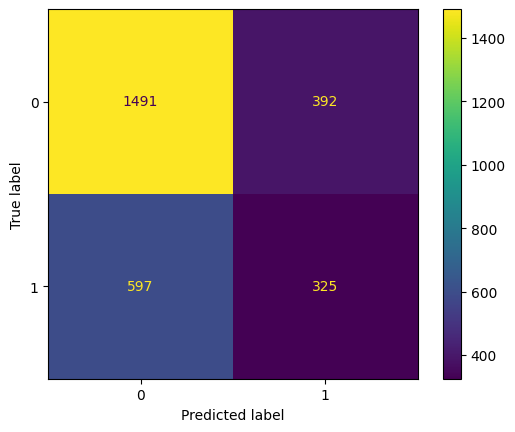

In [12]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

test = data_validation_labeled.drop(columns='label')
test_labels = data_validation_labeled.label
best_model = opt.best_estimator_
pred_y_test = best_model.predict(test)

print(f'Accuracy Score is {accuracy_score(test_labels,pred_y_test)}')
cm = confusion_matrix(test_labels, pred_y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();

In [15]:
cm = pd.DataFrame(cm, columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive'])

In [16]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, pred_y_test))

              precision    recall  f1-score   support

           0       0.71      0.79      0.75      1883
           1       0.45      0.35      0.40       922

    accuracy                           0.65      2805
   macro avg       0.58      0.57      0.57      2805
weighted avg       0.63      0.65      0.63      2805



In [17]:
classification_report = pd.DataFrame(classification_report(test_labels, pred_y_test,output_dict=True)).transpose()

## Proxy Model PDP-ALE and Counterfactual Explanations

In [18]:
missclassified = pd.concat([test, test_labels.rename('GroundTruth')], axis=1).reset_index(drop=True)
missclassified['Predicted'] = pred_y_test

In [19]:
def find_false_instances(test_df, false_positive=True):
    """
    Find false positive or false negative instances from the test data of a machine learning model.

    Args:
    - test_df (DataFrame): The test dataframe containing 'predicted' and 'actual' columns.
    - false_positive (bool): If True, find false positives, else find false negatives.

    Returns:
    - DataFrame: DataFrame containing false instances.
    """

    if false_positive:
        # Finding false positives
        false_instances = test_df[(test_df['Predicted'] == 1) & (test_df['GroundTruth'] == 0)]
    else:
        # Finding false negatives
        false_instances = test_df[(test_df['Predicted'] == 0) & (test_df['GroundTruth'] == 1)]

    return false_instances

In [20]:
def cf_difference(base_model, cf_df):
    """
    Calculate the difference between the base model and each row of the provided counterfactual DataFrame.
    
    Parameters:
    - base_model: DataFrame, representing the base model with hyperparameters
    - cf_df: DataFrame, representing the counterfactual DataFrame with hyperparameters
    
    Returns:
    - DataFrame with differences added as a new column
    """
    differences = []
    
    # Ensure the base_model DataFrame has only one row
    if len(base_model) != 1:
        raise ValueError("Base model DataFrame must have exactly one row.")

    # Get the single row of the base model
    base_row = base_model.iloc[0]
    
    # Iterate over each row in the counterfactual DataFrame
    for index, row in cf_df.iterrows():
        difference = 0
        
        # Iterate over each column in the counterfactual DataFrame
        for column, value in row.iteritems():
            # Exclude 'BinaryLabel' column
            if column == 'BinaryLabel':
                continue
            
            # Check if the column is numerical
            try:
                # Compute the absolute difference for numerical columns
                difference += abs(int(value) - int(base_row[column]))
            except:
                # For categorical values, difference is 1 if they are different
                if str(value) != str(base_row[column]):
                    difference += 1
                    
        # Append the difference for the current row
        differences.append(difference)
    
    # Add the differences as a new column in the counterfactual DataFrame
    cf_df['Difference'] = differences
    
    return cf_df

In [21]:
def get_scaler(scaler_str):
    if 'MinMaxScaler()' in scaler_str:
        return MinMaxScaler()
    elif 'RobustScaler()' in scaler_str:
        return RobustScaler()
    elif 'StandardScaler()' in scaler_str:
        return StandardScaler()
    else:
        return None

In [30]:
train = data_train_test.drop(columns='label')
train_labels = data_train_test.label
false_positives = find_false_instances(missclassified, false_positive=True)
proxy_model , proxy_dataset = instance_proxy(train,train_labels,opt, false_positives.loc[5].drop(columns=['GroundTruth','Predicted']),opt.param_grid)

In [31]:
import dice_ml

query = pd.DataFrame.from_dict(opt.best_params_,orient='index').T
query['preprocessor__num__scaler'] = query['preprocessor__num__scaler'].astype(str)
query['Model__learning_rate'] = query['Model__learning_rate'].astype(str)
proxy_dataset['Model__learning_rate'] = proxy_dataset['Model__learning_rate'].astype(str)

d = dice_ml.Data(dataframe=proxy_dataset, 
continuous_features=proxy_dataset.drop(columns='BinaryLabel').select_dtypes(include='number').columns.tolist()
, outcome_name='BinaryLabel')

# Using sklearn backend
m = dice_ml.Model(model=proxy_model, backend="sklearn")
# Using method=random for generating CFs
exp = dice_ml.Dice(d, m, method="random")

In [32]:
e1 = exp.generate_counterfactuals(query, total_CFs=5, desired_class="opposite",sample_size=5000)
e1.visualize_as_dataframe(show_only_changes=True)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

Query instance (original outcome : 1)


,Model__learning_rate,Model__max_depth,Model__min_child_weight,Model__n_estimators,preprocessor__num__scaler,BinaryLabel
0,0.1,2,1,75,StandardScaler(),1



Diverse Counterfactual set (new outcome: 0)


,Model__learning_rate,Model__max_depth,Model__min_child_weight,Model__n_estimators,preprocessor__num__scaler,BinaryLabel
0,0.001,-,-,-,-,0
1,-,6.0,-,27.0,-,0
2,-,8.0,-,25.0,-,0
3,0.001,-,-,-,-,0
4,0.01,-,-,25.0,-,0


In [24]:
import dice_ml
train = data_train_test.drop(columns='label')
train_labels = data_train_test.label
false_positives = find_false_instances(missclassified, false_positive=True)
def generate_cf_for_all(train,train_labels,instances,opt):
    no_cf = []
    found_cf = []
    proxy_not_fit = []
    cf_predicts_good = []
    false_instances = instances.copy(deep=True)
    false_instances.drop(columns=['GroundTruth','Predicted'],inplace=True)
    for i,row in false_instances.iterrows():
        try:
            proxy_model , proxy_dataset = instance_proxy(train,train_labels,opt, row.drop(columns=['GroundTruth','Predicted']),opt.param_grid)
        except:
            print(f'Proxy does not fit for instance {i}')
            proxy_not_fit.append(i)
            continue

        query = pd.DataFrame.from_dict(opt.best_params_,orient='index').T
        query['preprocessor__num__scaler'] = query['preprocessor__num__scaler'].astype(str)
        query['Model__learning_rate'] = query['Model__learning_rate'].astype(str)
        proxy_dataset['Model__learning_rate'] = proxy_dataset['Model__learning_rate'].astype(str)

        d = dice_ml.Data(dataframe=proxy_dataset, 
        continuous_features=proxy_dataset.drop(columns='BinaryLabel').select_dtypes(include='number').columns.tolist()
        , outcome_name='BinaryLabel')

        # Using sklearn backend
        m = dice_ml.Model(model=proxy_model, backend="sklearn")
        # Using method=random for generating CFs
        exp = dice_ml.Dice(d, m, method="random")
        try:
            e1 = exp.generate_counterfactuals(query, total_CFs=5, desired_class="opposite",sample_size=5000)
            #e1.visualize_as_dataframe(show_only_changes=True)
            found_cf.append(i)
        except:
            print("No counterfactuals found for ", i)
            no_cf.append(i)
            continue
        cfs = e1.cf_examples_list[0].final_cfs_df
        cf_df = cf_difference(query,cfs)
        cf_df = cf_df.sort_values(by='Difference')
        cf_df.reset_index(drop=True,inplace=True)
        cf = cf_df.loc[0].to_frame().T.drop(columns=['BinaryLabel','Difference'])
        cf['Model__learning_rate'] = cf["Model__learning_rate"].astype(float)
        cf['Model__max_depth'] = cf["Model__max_depth"].astype(int)
        cf['Model__min_child_weight'] = cf["Model__min_child_weight"].astype(int)
        cf['Model__n_estimators'] = cf["Model__n_estimators"].astype(int)
        cf['preprocessor__num__scaler'] = get_scaler(cf["preprocessor__num__scaler"].values[0])
        hyper_dict = cf.loc[0].to_dict()
        mdl = deepcopy(opt.estimator)
        mdl.set_params(**hyper_dict)
        mdl.fit(train, train_labels)
        pred = mdl.predict(row.to_frame().T)
        if pred[0] == instances.loc[i].to_frame().T['GroundTruth'].values[0]:
            cf_predicts_good.append(i)
            print("Counterfactual flips misclassified instance label correctly")

    return no_cf,found_cf,cf_predicts_good,proxy_not_fit
        

    #cfs = e1.cf_examples_list[0].final_cfs_df
    

In [20]:
no_cf,found_cf,cf_predicts_good,proxy_not_fit = generate_cf_for_all(train,train_labels,false_positives,opt)
false_positives_dict = {'no_cf':no_cf,
                        'found_cf':found_cf,
                        'cf_predicts_good': cf_predicts_good,
                        'proxy_not_fit':proxy_not_fit}

MODELS_DICT_PATH = 'false_positives_dict_big.pkl'
with open(MODELS_DICT_PATH, 'wb') as f:
            pickle.dump(false_positives_dict, f)
false_positives_dict

100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No counterfactuals found for  6



100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  2.06it/s]


Counterfactual flips misclassified instance label correctly
Proxy does not fit for instance 29


In [ ]:
no_cf,found_cf,cf_predicts_good,proxy_not_fit = generate_cf_for_all(train,train_labels,find_false_instances(missclassified, false_positive=False),opt)
false_negatives_dict = {'no_cf':no_cf,
                        'found_cf':found_cf,
                        'cf_predicts_good': cf_predicts_good,
                        'proxy_not_fit':proxy_not_fit}
MODELS_DICT_PATH = 'false_negatives_dict_big.pkl'
with open(MODELS_DICT_PATH, 'wb') as f:
            pickle.dump(false_negatives_dict, f)
false_negatives_dict

Proxy does not fit for instance 1883
Proxy does not fit for instance 1884


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]


Counterfactual flips misclassified instance label correctly
Proxy does not fit for instance 1886
Proxy does not fit for instance 1887
Proxy does not fit for instance 1888


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Counterfactual flips misclassified instance label correctly
Proxy does not fit for instance 1892
Proxy does not fit for instance 1893
Proxy does not fit for instance 1894
Proxy does not fit for instance 1895
Proxy does not fit for instance 1896


100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Counterfactual flips misclassified instance label correctly
Proxy does not fit for instance 1899


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  1904


Proxy does not fit for instance 1905
Proxy does not fit for instance 1906


100%|██████████| 1/1 [00:01<00:00,  1.44s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  1907



100%|██████████| 1/1 [00:01<00:00,  1.86s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  1909



100%|██████████| 1/1 [00:01<00:00,  1.57s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  1910



100%|██████████| 1/1 [00:00<00:00,  1.75it/s]


Counterfactual flips misclassified instance label correctly
Proxy does not fit for instance 1912
Proxy does not fit for instance 1913
Proxy does not fit for instance 1914
Proxy does not fit for instance 1915
Proxy does not fit for instance 1916
Proxy does not fit for instance 1917
Proxy does not fit for instance 1918
Proxy does not fit for instance 1919
Proxy does not fit for instance 1920
Proxy does not fit for instance 1921
Proxy does not fit for instance 1922
Proxy does not fit for instance 1923
Proxy does not fit for instance 1924
Proxy does not fit for instance 1925
Proxy does not fit for instance 1926
Proxy does not fit for instance 1927
Proxy does not fit for instance 1928
Proxy does not fit for instance 1929
Proxy does not fit for instance 1930
Proxy does not fit for instance 1931
Proxy does not fit for instance 1932
Proxy does not fit for instance 1933
Proxy does not fit for instance 1934
Proxy does not fit for instance 1935
Proxy does not fit for instance 1936
Proxy does not 

100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Counterfactual flips misclassified instance label correctly
Proxy does not fit for instance 1944
Proxy does not fit for instance 1945
Proxy does not fit for instance 1946
Proxy does not fit for instance 1947
Proxy does not fit for instance 1948
Proxy does not fit for instance 1949
Proxy does not fit for instance 1950
Proxy does not fit for instance 1951
Proxy does not fit for instance 1952
Proxy does not fit for instance 1953
Proxy does not fit for instance 1954
Proxy does not fit for instance 1955
Proxy does not fit for instance 1956
Proxy does not fit for instance 1957
Proxy does not fit for instance 1958
Proxy does not fit for instance 1959
Proxy does not fit for instance 1960
Proxy does not fit for instance 1961
Proxy does not fit for instance 1962
Proxy does not fit for instance 1963
Proxy does not fit for instance 1964


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


Counterfactual flips misclassified instance label correctly
Proxy does not fit for instance 1969
Proxy does not fit for instance 1970
Proxy does not fit for instance 1977
Proxy does not fit for instance 1978
Proxy does not fit for instance 1979


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  1980



100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  1981


Proxy does not fit for instance 1982


100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Counterfactual flips misclassified instance label correctly
Proxy does not fit for instance 1984
Proxy does not fit for instance 1985
Proxy does not fit for instance 1986
Proxy does not fit for instance 1987
Proxy does not fit for instance 1988
Proxy does not fit for instance 1989
Proxy does not fit for instance 1990
Proxy does not fit for instance 1991


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  1992



100%|██████████| 1/1 [00:01<00:00,  1.48s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  1993



100%|██████████| 1/1 [00:01<00:00,  1.34s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  1994



100%|██████████| 1/1 [00:01<00:00,  1.34s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  1995



100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  1996



100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  1997


Proxy does not fit for instance 1998
Proxy does not fit for instance 1999
Proxy does not fit for instance 2000


100%|██████████| 1/1 [00:01<00:00,  1.52s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2001


Proxy does not fit for instance 2002
Proxy does not fit for instance 2003
Proxy does not fit for instance 2004
Proxy does not fit for instance 2005
Proxy does not fit for instance 2006
Proxy does not fit for instance 2007
Proxy does not fit for instance 2008
Proxy does not fit for instance 2009
Proxy does not fit for instance 2010
Proxy does not fit for instance 2011
Proxy does not fit for instance 2012
Proxy does not fit for instance 2013
Proxy does not fit for instance 2014
Proxy does not fit for instance 2015
Proxy does not fit for instance 2016
Proxy does not fit for instance 2017
Proxy does not fit for instance 2018
Proxy does not fit for instance 2019
Proxy does not fit for instance 2020
Proxy does not fit for instance 2021
Proxy does not fit for instance 2022
Proxy does not fit for instance 2023
Proxy does not fit for instance 2024
Proxy does not fit for instance 2025
Proxy does not fit for instance 2026
Proxy does not fit for instance 2027
Proxy does not fit for instance 2028
P

100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:01<00:00,  1.61s/it]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:01<00:00,  1.55s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2039



100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:01<00:00,  1.74s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2046



100%|██████████| 1/1 [00:01<00:00,  1.86s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2047



100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:01<00:00,  1.75s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2050



100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2051


Proxy does not fit for instance 2052
Proxy does not fit for instance 2053


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Counterfactual flips misclassified instance label correctly
Proxy does not fit for instance 2059
Proxy does not fit for instance 2060
Proxy does not fit for instance 2061
Proxy does not fit for instance 2062
Proxy does not fit for instance 2063
Proxy does not fit for instance 2064
Proxy does not fit for instance 2065
Proxy does not fit for instance 2066
Proxy does not fit for instance 2067
Proxy does not fit for instance 2068
Proxy does not fit for instance 2069
Proxy does not fit for instance 2070
Proxy does not fit for instance 2071
Proxy does not fit for instance 2072
Proxy does not fit for instance 2073


100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Counterfactual flips misclassified instance label correctly
Proxy does not fit for instance 2075
Proxy does not fit for instance 2076
Proxy does not fit for instance 2077
Proxy does not fit for instance 2078
Proxy does not fit for instance 2079
Proxy does not fit for instance 2080


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:01<00:00,  1.60s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2086


Proxy does not fit for instance 2087
Proxy does not fit for instance 2088
Proxy does not fit for instance 2089
Proxy does not fit for instance 2090
Proxy does not fit for instance 2091
Proxy does not fit for instance 2092
Proxy does not fit for instance 2093
Proxy does not fit for instance 2094
Proxy does not fit for instance 2095
Proxy does not fit for instance 2096
Proxy does not fit for instance 2097
Proxy does not fit for instance 2098
Proxy does not fit for instance 2099
Proxy does not fit for instance 2100


100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:01<00:00,  1.40s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2102



100%|██████████| 1/1 [00:01<00:00,  1.49s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2104



100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2105



100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Proxy does not fit for instance 2107
Proxy does not fit for instance 2108
Proxy does not fit for instance 2109
Proxy does not fit for instance 2110
Proxy does not fit for instance 2111
Proxy does not fit for instance 2112
Proxy does not fit for instance 2113
Proxy does not fit for instance 2114
Proxy does not fit for instance 2115
Proxy does not fit for instance 2116
Proxy does not fit for instance 2117
Proxy does not fit for instance 2118


100%|██████████| 1/1 [00:01<00:00,  1.46s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2119



100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2120



100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:01<00:00,  1.50s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2126



100%|██████████| 1/1 [00:02<00:00,  2.32s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 02 sec
No counterfactuals found for  2127



100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2129



100%|██████████| 1/1 [00:03<00:00,  3.60s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec
No counterfactuals found for  2130



100%|██████████| 1/1 [00:01<00:00,  1.73s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2131


Proxy does not fit for instance 2132


100%|██████████| 1/1 [00:01<00:00,  1.63s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2133



100%|██████████| 1/1 [00:02<00:00,  2.06s/it]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:01<00:00,  1.93s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2135



100%|██████████| 1/1 [00:01<00:00,  1.89s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2136


Proxy does not fit for instance 2137
Proxy does not fit for instance 2138
Proxy does not fit for instance 2139
Proxy does not fit for instance 2140
Proxy does not fit for instance 2141
Proxy does not fit for instance 2142
Proxy does not fit for instance 2143


100%|██████████| 1/1 [00:01<00:00,  1.54s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2144



100%|██████████| 1/1 [00:01<00:00,  1.58s/it]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:01<00:00,  1.61s/it]


Counterfactual flips misclassified instance label correctly
Proxy does not fit for instance 2149
Proxy does not fit for instance 2150
Proxy does not fit for instance 2151


100%|██████████| 1/1 [00:01<00:00,  1.40s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2152



100%|██████████| 1/1 [00:01<00:00,  1.57s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2153


Proxy does not fit for instance 2154


100%|██████████| 1/1 [00:02<00:00,  2.02s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 02 sec
No counterfactuals found for  2155


Proxy does not fit for instance 2156
Proxy does not fit for instance 2157
Proxy does not fit for instance 2158
Proxy does not fit for instance 2159
Proxy does not fit for instance 2160
Proxy does not fit for instance 2161


100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Counterfactual flips misclassified instance label correctly
Proxy does not fit for instance 2166
Proxy does not fit for instance 2167
Proxy does not fit for instance 2168


100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


Counterfactual flips misclassified instance label correctly
Proxy does not fit for instance 2170


100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Counterfactual flips misclassified instance label correctly
Proxy does not fit for instance 2177
Proxy does not fit for instance 2181
Proxy does not fit for instance 2182
Proxy does not fit for instance 2183
Proxy does not fit for instance 2184
Proxy does not fit for instance 2185
Proxy does not fit for instance 2186
Proxy does not fit for instance 2187
Proxy does not fit for instance 2188


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


Proxy does not fit for instance 2194


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:01<00:00,  1.50s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2196



100%|██████████| 1/1 [00:01<00:00,  1.51s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2197


Proxy does not fit for instance 2198
Proxy does not fit for instance 2199
Proxy does not fit for instance 2200


100%|██████████| 1/1 [00:01<00:00,  1.66s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2201



100%|██████████| 1/1 [00:01<00:00,  1.69s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2202


Proxy does not fit for instance 2208
Proxy does not fit for instance 2209
Proxy does not fit for instance 2210
Proxy does not fit for instance 2211
Proxy does not fit for instance 2212
Proxy does not fit for instance 2213


100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:01<00:00,  1.64s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2216


Proxy does not fit for instance 2217
Proxy does not fit for instance 2218


100%|██████████| 1/1 [00:01<00:00,  1.56s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2219



100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:01<00:00,  1.62s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2223


Proxy does not fit for instance 2224
Proxy does not fit for instance 2225
Proxy does not fit for instance 2226


100%|██████████| 1/1 [00:01<00:00,  1.53s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2227


Proxy does not fit for instance 2228


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:01<00:00,  1.75s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2232


Proxy does not fit for instance 2233
Proxy does not fit for instance 2234
Proxy does not fit for instance 2235
Proxy does not fit for instance 2236
Proxy does not fit for instance 2237
Proxy does not fit for instance 2238
Proxy does not fit for instance 2239
Proxy does not fit for instance 2240
Proxy does not fit for instance 2241
Proxy does not fit for instance 2242
Proxy does not fit for instance 2243
Proxy does not fit for instance 2244
Proxy does not fit for instance 2245
Proxy does not fit for instance 2246
Proxy does not fit for instance 2247


100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Counterfactual flips misclassified instance label correctly
Proxy does not fit for instance 2251


100%|██████████| 1/1 [00:01<00:00,  1.58s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2252



100%|██████████| 1/1 [00:01<00:00,  1.58s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2253



100%|██████████| 1/1 [00:01<00:00,  1.97s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2254



100%|██████████| 1/1 [00:01<00:00,  1.59s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2255



100%|██████████| 1/1 [00:01<00:00,  1.55s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2256


Proxy does not fit for instance 2257
Proxy does not fit for instance 2258
Proxy does not fit for instance 2259
Proxy does not fit for instance 2260
Proxy does not fit for instance 2261
Proxy does not fit for instance 2262


100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


Counterfactual flips misclassified instance label correctly
Proxy does not fit for instance 2264
Proxy does not fit for instance 2265
Proxy does not fit for instance 2266


100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Counterfactual flips misclassified instance label correctly
Proxy does not fit for instance 2271
Proxy does not fit for instance 2272
Proxy does not fit for instance 2273
Proxy does not fit for instance 2274


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


Counterfactual flips misclassified instance label correctly
Proxy does not fit for instance 2278
Proxy does not fit for instance 2279
Proxy does not fit for instance 2280
Proxy does not fit for instance 2281
Proxy does not fit for instance 2282


100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:01<00:00,  1.55s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2285


Proxy does not fit for instance 2286


100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Counterfactual flips misclassified instance label correctly
Proxy does not fit for instance 2289
Proxy does not fit for instance 2290
Proxy does not fit for instance 2291
Proxy does not fit for instance 2292
Proxy does not fit for instance 2293
Proxy does not fit for instance 2294


100%|██████████| 1/1 [00:01<00:00,  1.67s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2295


Proxy does not fit for instance 2296
Proxy does not fit for instance 2297
Proxy does not fit for instance 2298
Proxy does not fit for instance 2299
Proxy does not fit for instance 2300
Proxy does not fit for instance 2301
Proxy does not fit for instance 2302
Proxy does not fit for instance 2303
Proxy does not fit for instance 2304
Proxy does not fit for instance 2305
Proxy does not fit for instance 2306
Proxy does not fit for instance 2307
Proxy does not fit for instance 2308
Proxy does not fit for instance 2309
Proxy does not fit for instance 2310
Proxy does not fit for instance 2311
Proxy does not fit for instance 2312
Proxy does not fit for instance 2314
Proxy does not fit for instance 2315


100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Counterfactual flips misclassified instance label correctly
Proxy does not fit for instance 2319
Proxy does not fit for instance 2320
Proxy does not fit for instance 2321
Proxy does not fit for instance 2322
Proxy does not fit for instance 2323
Proxy does not fit for instance 2324


100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:01<00:00,  1.70s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2328


Proxy does not fit for instance 2330
Proxy does not fit for instance 2331
Proxy does not fit for instance 2332


100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:01<00:00,  1.58s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2334



100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:01<00:00,  1.88s/it]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:01<00:00,  1.55s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2337


Proxy does not fit for instance 2338
Proxy does not fit for instance 2339
Proxy does not fit for instance 2340
Proxy does not fit for instance 2341
Proxy does not fit for instance 2342
Proxy does not fit for instance 2343
Proxy does not fit for instance 2344
Proxy does not fit for instance 2345
Proxy does not fit for instance 2346
Proxy does not fit for instance 2347
Proxy does not fit for instance 2348


100%|██████████| 1/1 [00:01<00:00,  1.72s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2349



100%|██████████| 1/1 [00:01<00:00,  1.64s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2352



100%|██████████| 1/1 [00:01<00:00,  1.52s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2353



100%|██████████| 1/1 [00:01<00:00,  1.53s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2360



100%|██████████| 1/1 [00:01<00:00,  1.49s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2361


Proxy does not fit for instance 2362
Proxy does not fit for instance 2363
Proxy does not fit for instance 2364
Proxy does not fit for instance 2365
Proxy does not fit for instance 2366


100%|██████████| 1/1 [00:01<00:00,  1.75s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2387



100%|██████████| 1/1 [00:01<00:00,  1.84s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2388


Proxy does not fit for instance 2389


100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:01<00:00,  1.64s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2443


Proxy does not fit for instance 2445
Proxy does not fit for instance 2446
Proxy does not fit for instance 2447


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:01<00:00,  1.53s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2458



100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Proxy does not fit for instance 2481
Proxy does not fit for instance 2482


100%|██████████| 1/1 [00:01<00:00,  1.59s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2483


Proxy does not fit for instance 2484
Proxy does not fit for instance 2485


100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Counterfactual flips misclassified instance label correctly
Proxy does not fit for instance 2487


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


Counterfactual flips misclassified instance label correctly
Proxy does not fit for instance 2489
Proxy does not fit for instance 2490
Proxy does not fit for instance 2491
Proxy does not fit for instance 2492
Proxy does not fit for instance 2493
Proxy does not fit for instance 2494


100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Proxy does not fit for instance 2498
Proxy does not fit for instance 2499


100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 02 sec
No counterfactuals found for  2506


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


Counterfactual flips misclassified instance label correctly
Proxy does not fit for instance 2511


100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:01<00:00,  1.74s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2528



100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Counterfactual flips misclassified instance label correctly
Proxy does not fit for instance 2542
Proxy does not fit for instance 2543
Proxy does not fit for instance 2544
Proxy does not fit for instance 2545
Proxy does not fit for instance 2546
Proxy does not fit for instance 2547
Proxy does not fit for instance 2548


100%|██████████| 1/1 [00:01<00:00,  1.97s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2549



100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:01<00:00,  1.63s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2629



100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:01<00:00,  1.60s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2641



100%|██████████| 1/1 [00:01<00:00,  1.49s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2644



100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2659



100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Proxy does not fit for instance 2663


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Counterfactual flips misclassified instance label correctly
Proxy does not fit for instance 2686
Proxy does not fit for instance 2687
Proxy does not fit for instance 2688


100%|██████████| 1/1 [00:01<00:00,  1.59s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2689



100%|██████████| 1/1 [00:02<00:00,  2.05s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 02 sec
No counterfactuals found for  2690


Proxy does not fit for instance 2691
Proxy does not fit for instance 2692


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:01<00:00,  1.61s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2711



100%|██████████| 1/1 [00:01<00:00,  1.56s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2712



100%|██████████| 1/1 [00:01<00:00,  1.65s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2713



100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2721


Proxy does not fit for instance 2722


100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:01<00:00,  1.46s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2737



100%|██████████| 1/1 [00:01<00:00,  1.80s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2738



100%|██████████| 1/1 [00:01<00:00,  1.61s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2739



100%|██████████| 1/1 [00:01<00:00,  1.60s/it]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Counterfactual flips misclassified instance label correctly
Proxy does not fit for instance 2774


100%|██████████| 1/1 [00:01<00:00,  1.54s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2775



100%|██████████| 1/1 [00:01<00:00,  1.55s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2776



100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Proxy does not fit for instance 2789
Proxy does not fit for instance 2793


100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


Counterfactual flips misclassified instance label correctly
Proxy does not fit for instance 2796
Proxy does not fit for instance 2797


100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Counterfactual flips misclassified instance label correctly
Proxy does not fit for instance 2799


100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:01<00:00,  1.43s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No counterfactuals found for  2802



100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Counterfactual flips misclassified instance label correctly


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Counterfactual flips misclassified instance label correctly


{'no_cf': [1904,
  1907,
  1909,
  1910,
  1980,
  1981,
  1992,
  1993,
  1994,
  1995,
  1996,
  1997,
  2001,
  2039,
  2046,
  2047,
  2050,
  2051,
  2086,
  2102,
  2104,
  2105,
  2119,
  2120,
  2126,
  2127,
  2129,
  2130,
  2131,
  2133,
  2135,
  2136,
  2144,
  2152,
  2153,
  2155,
  2196,
  2197,
  2201,
  2202,
  2216,
  2219,
  2223,
  2227,
  2232,
  2252,
  2253,
  2254,
  2255,
  2256,
  2285,
  2295,
  2328,
  2334,
  2337,
  2349,
  2352,
  2353,
  2360,
  2361,
  2387,
  2388,
  2443,
  2458,
  2483,
  2506,
  2528,
  2549,
  2629,
  2641,
  2644,
  2659,
  2689,
  2690,
  2711,
  2712,
  2713,
  2721,
  2737,
  2738,
  2739,
  2775,
  2776,
  2802],
 'found_cf': [1885,
  1889,
  1890,
  1891,
  1897,
  1898,
  1901,
  1908,
  1911,
  1942,
  1943,
  1965,
  1966,
  1967,
  1968,
  1983,
  2036,
  2037,
  2038,
  2040,
  2041,
  2042,
  2043,
  2044,
  2045,
  2048,
  2049,
  2054,
  2055,
  2056,
  2057,
  2074,
  2081,
  2082,
  2083,
  2101,
  2103,
  2106,
  

In [27]:
print('No cf found for false_positives',len(false_positives_dict['no_cf']))
print('CF found for false_positives',len(false_positives_dict['found_cf']))
print('CF predicts good found for false_positives',len(false_positives_dict['cf_predicts_good']))
print('Proxy didnt fit for',len(false_positives_dict['proxy_not_fit']))

No cf found for false_positives 13
CF found for false_positives 379
CF predicts good found for false_positives 342
Proxy didnt fit for 0


In [28]:
print('No cf found for false_negatives',len(false_negatives_dict['no_cf']))
print('CF found for false_negatives',len(false_negatives_dict['found_cf']))
print('CF predicts good found for false_negatives',len(false_negatives_dict['cf_predicts_good']))
print('Proxy didnt fit for',len(false_negatives_dict['proxy_not_fit']))

No cf found for false_negatives 84
CF found for false_negatives 179
CF predicts good found for false_negatives 141
Proxy didnt fit for 334
